# HDCNN for Architecture Image Recognition

## Setup and Imports

**Import Packages**

In [222]:
import keras as kr
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()


from keras.datasets import cifar100

from sklearn.model_selection import train_test_split

from random import randint
import time
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [223]:
if not os.path.exists('data/models/'):
    os.mkdir('data/models')

**Define Global Variables**

In [224]:
# The number of coarse categories
coarse_categories = 11

# The number of fine categories
fine_categories = 25

## Import and Preprocess Dataset

In [225]:
import random
import keras_preprocessing.image

def load_and_crop_img(path, grayscale=False, color_mode='rgb', target_size=None,
             interpolation='nearest'):
    """Wraps keras_preprocessing.image.utils.loag_img() and adds cropping.
    Cropping method enumarated in interpolation
    # Arguments
        path: Path to image file.
        color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
            The desired image format.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation and crop methods used to resample and crop the image
            if the target size is different from that of the loaded image.
            Methods are delimited by ":" where first part is interpolation and second is crop
            e.g. "lanczos:random".
            Supported interpolation methods are "nearest", "bilinear", "bicubic", "lanczos",
            "box", "hamming" By default, "nearest" is used.
            Supported crop methods are "none", "center", "random".
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """

    # Decode interpolation string. Allowed Crop methods: none, center, random
    interpolation, crop = interpolation.split(":") if ":" in interpolation else (interpolation, "none")  

    if crop == "none":
        return keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=target_size,
                                            interpolation=interpolation)

    # Load original size image using Keras
    img = keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=None, 
                                            interpolation=interpolation)

    # Crop fraction of total image
    crop_fraction = 0.875
    target_width = target_size[1]
    target_height = target_size[0]

    if target_size is not None:        
        if img.size != (target_width, target_height):

            if crop not in ["center", "random"]:
                raise ValueError('Invalid crop method {} specified.', crop)

            if interpolation not in keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(interpolation,
                        ", ".join(keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS.keys())))
            
            resample = keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS[interpolation]

            width, height = img.size

            # Resize keeping aspect ratio
            # result shold be no smaller than the targer size, include crop fraction overhead
            target_size_before_crop = (target_width/crop_fraction, target_height/crop_fraction)
            ratio = max(target_size_before_crop[0] / width, target_size_before_crop[1] / height)
            target_size_before_crop_keep_ratio = int(width * ratio), int(height * ratio)
            img = img.resize(target_size_before_crop_keep_ratio, resample=resample)

            width, height = img.size

            if crop == "center":
                left_corner = int(round(width/2)) - int(round(target_width/2))
                top_corner = int(round(height/2)) - int(round(target_height/2))
                return img.crop((left_corner, top_corner, left_corner + target_width, top_corner + target_height))
            elif crop == "random":
                left_shift = random.randint(0, int((width - target_width)))
                down_shift = random.randint(0, int((height - target_height)))
                return img.crop((left_shift, down_shift, target_width + left_shift, target_height + down_shift))

    return img
  
keras_preprocessing.image.iterator.load_img = load_and_crop_img

In [226]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
fine_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=15,
    horizontal_flip=True,
    samplewise_std_normalization = True)
fine_dir = "/content/drive/MyDrive/CS135_final_data/fine_standard"
fine_img = fine_datagen.flow_from_directory(fine_dir,target_size=(64,64), batch_size=128, interpolation = 'lanczos:center', shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 10113 images belonging to 25 classes.


In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
from tqdm import tqdm
fine_img.reset()
X_fine, y_fine = next(fine_img)
for i in tqdm(range(int(len(fine_img))-1)): #1st batch is already fetched before the for loop.
  img, label = next(fine_img)
  X_fine = np.append(X_fine, img, axis=0)
  y_fine = np.append(y_fine, label, axis=0)
print(X_fine.shape, y_fine.shape)

100%|██████████| 79/79 [02:46<00:00,  2.10s/it]

(10113, 64, 64, 3) (10113, 25)


**Fine-To-Coarse Mapping**

(Ideally, this would be done through spectral clustering as opposed to hard-coding)

In [229]:
# 9 classification
fine2coarse = np.zeros((fine_categories,coarse_categories))
fine2coarse[0,0] = 1
fine2coarse[1,5] = 1
fine2coarse[2,5] = 1
fine2coarse[3,0] = 1
fine2coarse[4,9] = 1
fine2coarse[5,10] = 1
fine2coarse[6,3] = 1
fine2coarse[7,7] = 1
fine2coarse[8,4] = 1
fine2coarse[9,2] = 1
fine2coarse[10,6] = 1
fine2coarse[11,5] = 1
fine2coarse[12,8] = 1
fine2coarse[13,9] = 1
fine2coarse[14,4] = 1
fine2coarse[15,2] = 1
fine2coarse[16,4] = 1
fine2coarse[17,6] = 1
fine2coarse[18,7] = 1
fine2coarse[19,3] = 1
fine2coarse[20,8] = 1
fine2coarse[21,5] = 1
fine2coarse[22,1] = 1
fine2coarse[23,4] = 1
fine2coarse[24,9] = 1

In [230]:
# 5 classification
# fine2coarse = np.zeros((fine_categories,coarse_categories))
# fine2coarse[0,0] = 1
# fine2coarse[1,2] = 1
# fine2coarse[2,2] = 1
# fine2coarse[3,0] = 1
# fine2coarse[4,2] = 1
# fine2coarse[5,2] = 1
# fine2coarse[6,1] = 1
# fine2coarse[7,3] = 1
# fine2coarse[8,2] = 1
# fine2coarse[9,1] = 1
# fine2coarse[10,2] = 1
# fine2coarse[11,3] = 1
# fine2coarse[12,2] = 1
# fine2coarse[13,1] = 1
# fine2coarse[14,3] = 1
# fine2coarse[15,3] = 1
# fine2coarse[16,1] = 1
# fine2coarse[17,3] = 1
# fine2coarse[18,2] = 1
# fine2coarse[19,1] = 1
# fine2coarse[20,3] = 1
# fine2coarse[21,4] = 1
# fine2coarse[22,1] = 1
# fine2coarse[23,4] = 1
# fine2coarse[24,4] = 1

In [231]:
# 2 classification
# fine2coarse = np.zeros((fine_categories,coarse_categories))
# fine2coarse[0,0] = 1
# fine2coarse[1,1] = 1
# fine2coarse[2,1] = 1
# fine2coarse[3,0] = 1
# fine2coarse[4,1] = 1
# fine2coarse[5,1] = 1
# fine2coarse[6,0] = 1
# fine2coarse[7,1] = 1
# fine2coarse[8,0] = 1
# fine2coarse[9,0] = 1
# fine2coarse[10,1] = 1
# fine2coarse[11,1] = 1
# fine2coarse[12,1] = 1
# fine2coarse[13,1] = 1
# fine2coarse[14,0] = 1
# fine2coarse[15,0] = 1
# fine2coarse[16,0] = 1
# fine2coarse[17,1] = 1
# fine2coarse[18,1] = 1
# fine2coarse[19,0] = 1
# fine2coarse[20,1] = 1
# fine2coarse[21,1] = 1
# fine2coarse[22,0] = 1
# fine2coarse[23,0] = 1
# fine2coarse[24,1] = 1

In [232]:
# with np.printoptions(threshold=np.inf):
#     print(fine2coarse)

**Split Training set into Training and Validation sets**

In [233]:
x_train, x_val, y_train, y_val = train_test_split(X_fine, y_fine, test_size=.2,random_state=1234)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


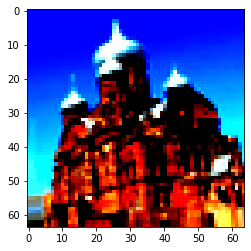

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23]


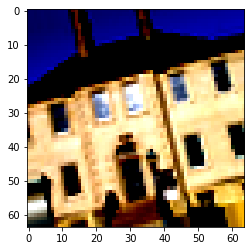

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14]


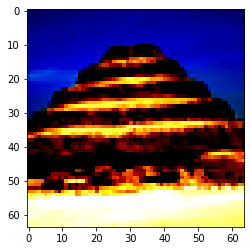

[3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


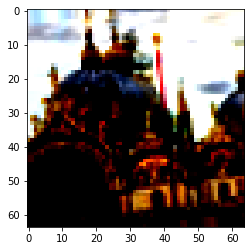

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9]


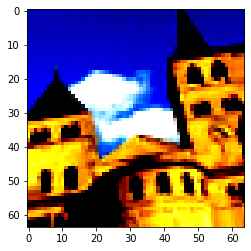

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22]


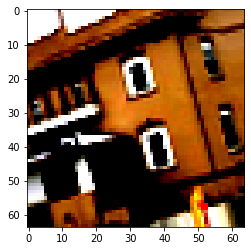

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2]


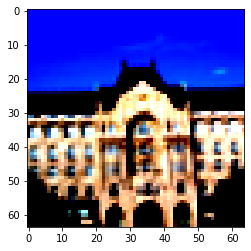

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


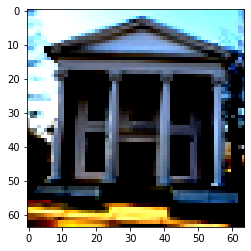

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16]


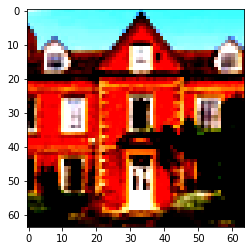

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21]


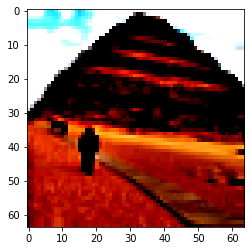

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3]


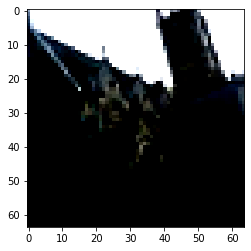

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23]


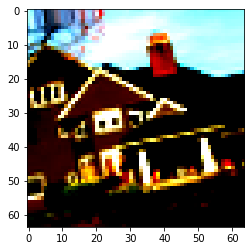

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14]


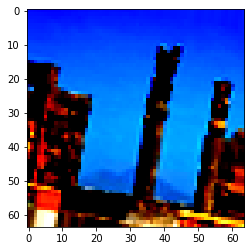

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3]


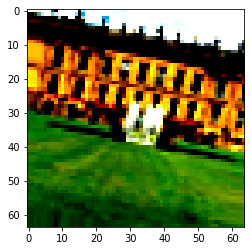

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9]


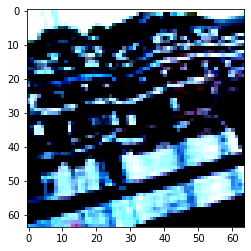

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[22]


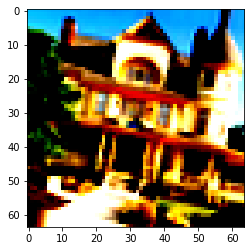

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2]


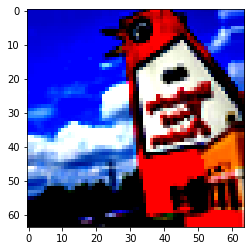

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


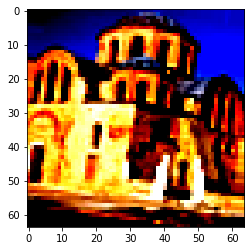

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16]


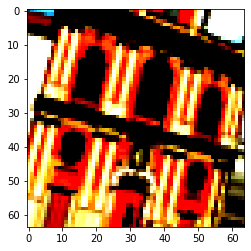

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21]


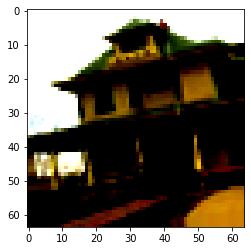

[3]


In [234]:
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

for i in range(0,10):
    image = x_train[i]
    plt.imshow(image)
    plt.show()
    print(np.where(y_train[i] == 1)[0])


for i in range(0,10):
    image = x_val[i]
    plt.imshow(image)
    plt.show()
    print(np.where(y_train[i] == 1)[0])

In [235]:
# y_fine_eight = y_fine[np.argwhere(y_fine==1)[:,1] < 8]
# X_fine_eight = X_fine[np.argwhere(y_fine==1)[:,1] < 8]
# x_train_eight, x_val_eight, y_train_eight, y_val_eight = train_test_split(X_fine_eight, y_fine_eight, test_size=.1,shuffle=True)

**Constructing CNN**

In [236]:
from keras import optimizers
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.models import Model

in_layer = Input(shape=(64,64, 3), dtype='float32', name='main_input')

net = Conv2D(64, 3, strides=1, padding='same', activation='relu')(in_layer)
net = BatchNormalization()(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(128, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.1)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(256, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.2)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Flatten()(net)

net = Dense(1024, activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = Dense(25, activation='softmax')(net)

**Compile Model**

In [237]:
model = Model(inputs=in_layer,outputs=net)
adam_coarse = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= adam_coarse, loss='categorical_crossentropy', metrics=['accuracy'])
tbCallBack = kr.callbacks.TensorBoard(log_dir='./data/graph/relu_drop/', histogram_freq=0, write_graph=True, write_images=True)

In [238]:
batch = 16

**Train Model**

In [239]:
index= 0
step = 5
stop = 30


while index < stop:
    model.fit(x_train, y_train, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val), callbacks=[tbCallBack])
    index += step
    model.save_weights('data/models/model_coarse'+str(index))

save_index = index

Train on 8090 samples, validate on 2023 samples
Epoch 1/5
8048/8090 [============================>.] - ETA: 0s - loss: 3.1264 - acc: 0.1582

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8090/8090 [==============================] - 11s 1ms/sample - loss: 3.1235 - acc: 0.1588 - val_loss: 3.8292 - val_acc: 0.1918
Epoch 2/5
8090/8090 [==============================] - 7s 866us/sample - loss: 2.5949 - acc: 0.2551 - val_loss: 3.1308 - val_acc: 0.2373
Epoch 3/5
8090/8090 [==============================] - 7s 866us/sample - loss: 2.3046 - acc: 0.3252 - val_loss: 2.5011 - val_acc: 0.2862
Epoch 4/5
8090/8090 [==============================] - 7s 862us/sample - loss: 2.0635 - acc: 0.3812 - val_loss: 2.6062 - val_acc: 0.3554
Epoch 5/5
8090/8090 [==============================] - 7s 862us/sample - loss: 1.8516 - acc: 0.4370 - val_loss: 2.8765 - val_acc: 0.3267
Train on 8090 samples, validate on 2023 samples
Epoch 6/10
8090/8090 [==============================] - 7s 871us/sample - loss: 1.6370 - acc: 0.4953 - val_loss: 4.2042 - val_acc: 0.2091
Epoch 7/10
8090/8090 [==============================] - 7s 868us/sample - loss: 1.4873 - acc: 0.5422 - val_loss: 2.5961 - val_acc: 0.3618
Ep

In [240]:
# index= 0
# step = 5
# stop = 40
# batch = 64
# while index < stop:
#     model.fit(x_train_eight, y_train_eight, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val_eight, y_val_eight), callbacks=[tbCallBack])
#     index += step
#     model.save_weights('data/models/model_coarse'+str(index))
# save_index = index

### Load Most Recent Model

In [241]:
adam_fine =  tf.keras.optimizers.Adam(learning_rate=0.0001)

In [242]:
for i in range(len(model.layers)):
    model.layers[i].trainable=False

## Fine-Tuning for Coarse Classifier

In [243]:
y_train_c = np.dot(y_train,fine2coarse)
y_val_c = np.dot(y_val,fine2coarse)

In [244]:
net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(model.layers[-10].output)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Flatten()(net)

net = Dense(1024, activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
out_coarse = Dense(11, activation='softmax')(net)

model_c = Model(inputs=in_layer,outputs=out_coarse)
model_c.compile(optimizer= adam_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

for i in range(len(model_c.layers)-1):
    model_c.layers[i].set_weights(model.layers[i].get_weights())

In [245]:
index = 30
step = 10
stop = 40

while index < stop:
    model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 8090 samples, validate on 2023 samples
Epoch 31/40
8080/8090 [============================>.] - ETA: 0s - loss: 1.0876 - acc: 0.6361

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8090/8090 [==============================] - 9s 1ms/sample - loss: 1.0878 - acc: 0.6362 - val_loss: 2.3784 - val_acc: 0.4523
Epoch 32/40
8090/8090 [==============================] - 5s 644us/sample - loss: 0.5174 - acc: 0.8150 - val_loss: 2.5137 - val_acc: 0.4770
Epoch 33/40
8090/8090 [==============================] - 5s 646us/sample - loss: 0.3330 - acc: 0.8870 - val_loss: 2.3508 - val_acc: 0.4834
Epoch 34/40
8090/8090 [==============================] - 5s 644us/sample - loss: 0.2427 - acc: 0.9133 - val_loss: 2.7551 - val_acc: 0.4909
Epoch 35/40
8090/8090 [==============================] - 5s 646us/sample - loss: 0.2092 - acc: 0.9290 - val_loss: 2.8125 - val_acc: 0.4869
Epoch 36/40
8090/8090 [==============================] - 5s 649us/sample - loss: 0.1713 - acc: 0.9407 - val_loss: 2.9597 - val_acc: 0.4993
Epoch 37/40
8090/8090 [==============================] - 5s 648us/sample - loss: 0.1540 - acc: 0.9472 - val_loss: 2.9875 - val_acc: 0.5190
Epoch 38/40
8090/8090 [==================

In [246]:
model_c.compile(optimizer= adam_fine, loss='categorical_crossentropy', metrics=['accuracy'])
stop = 50

while index < stop:
    model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 8090 samples, validate on 2023 samples
Epoch 41/50
8080/8090 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9660

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0981 - acc: 0.9658 - val_loss: 3.1869 - val_acc: 0.5052
Epoch 42/50
8090/8090 [==============================] - 5s 650us/sample - loss: 0.0846 - acc: 0.9718 - val_loss: 3.1988 - val_acc: 0.5101
Epoch 43/50
8090/8090 [==============================] - 5s 654us/sample - loss: 0.0733 - acc: 0.9744 - val_loss: 3.1957 - val_acc: 0.5077
Epoch 44/50
8090/8090 [==============================] - 5s 652us/sample - loss: 0.0677 - acc: 0.9789 - val_loss: 3.2019 - val_acc: 0.5067
Epoch 45/50
8090/8090 [==============================] - 5s 643us/sample - loss: 0.0686 - acc: 0.9768 - val_loss: 3.1738 - val_acc: 0.5106
Epoch 46/50
8090/8090 [==============================] - 5s 648us/sample - loss: 0.0542 - acc: 0.9824 - val_loss: 3.2125 - val_acc: 0.5057
Epoch 47/50
8090/8090 [==============================] - 5s 645us/sample - loss: 0.0527 - acc: 0.9822 - val_loss: 3.2178 - val_acc: 0.5082
Epoch 48/50
8090/8090 [==================

## Fine-Tuning for Fine Classifiers

### Construct Fine Classifiers

In [247]:
def fine_model():

    net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(model.layers[-10].output)
    net = BatchNormalization()(net)
    net = Dropout(.3)(net)
    net = MaxPooling2D((2, 2), padding='valid')(net)

    net = Flatten()(net)

    net = Dense(1024, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(.3)(net)
    out_fine = Dense(25, activation='softmax')(net)


    model_fine = Model(inputs=in_layer,outputs=out_fine)
    model_fine.compile(optimizer= adam_coarse,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    for i in range(len(model_fine.layers)-1):
        model_fine.layers[i].set_weights(model.layers[i].get_weights())
    return model_fine

In [248]:
fine_models = {'models' : [{} for i in range(coarse_categories)], 'yhf' : [{} for i in range(coarse_categories)]}
for i in range(coarse_categories):
    model_i = fine_model()
    fine_models['models'][i] = model_i

### Train Fine Classifiers on Respective Data

In [249]:
def get_error(y,yh):
    # Threshold 
    yht = np.zeros(np.shape(yh))
    yht[np.arange(len(yh)), yh.argmax(1)] = 1
    # Evaluate Error
    error = np.count_nonzero(np.count_nonzero(y-yht,1))/len(y)
    return error

In [250]:
for i in range(coarse_categories):
    index= 0
    step = 5
    stop = 15
    
    # Get all training data for the coarse category
    ix = np.where([(y_train[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_tix = x_train[ix]
    y_tix = y_train[ix]
    
    # Get all validation data for the coarse category
    ix_v = np.where([(y_val[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_vix = x_val[ix_v]
    y_vix = y_val[ix_v]
    
    while index < stop:
        fine_models['models'][i].fit(x_tix, y_tix, batch_size=16, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
        index += step
    
    # fine_models['models'][i].compile(optimizer=adam_fine, loss='categorical_crossentropy', metrics=['accuracy'])
    # stop = 10

    # while index < stop:
    #     fine_models['models'][i].fit(x_tix, y_tix, batch_size=16, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
    #     index += step
        
    yh_f = fine_models['models'][i].predict(x_val[ix_v], batch_size=batch)
    print('Fine Classifier '+str(i)+' Error: '+str(get_error(y_val[ix_v],yh_f))) 

Train on 644 samples, validate on 154 samples
Epoch 1/5
576/644 [=========================>....] - ETA: 0s - loss: 0.7456 - acc: 0.8160

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


644/644 [==============================] - 4s 7ms/sample - loss: 0.7224 - acc: 0.8230 - val_loss: 1.6426 - val_acc: 0.7922
Epoch 2/5
644/644 [==============================] - 0s 700us/sample - loss: 0.2305 - acc: 0.9301 - val_loss: 1.4795 - val_acc: 0.7597
Epoch 3/5
644/644 [==============================] - 0s 689us/sample - loss: 0.0896 - acc: 0.9689 - val_loss: 1.0397 - val_acc: 0.7727
Epoch 4/5
644/644 [==============================] - 0s 683us/sample - loss: 0.0548 - acc: 0.9798 - val_loss: 0.8181 - val_acc: 0.8117
Epoch 5/5
644/644 [==============================] - 0s 676us/sample - loss: 0.0312 - acc: 0.9876 - val_loss: 0.8925 - val_acc: 0.7987
Train on 644 samples, validate on 154 samples
Epoch 6/10
644/644 [==============================] - 0s 669us/sample - loss: 0.0235 - acc: 0.9953 - val_loss: 0.8000 - val_acc: 0.8182
Epoch 7/10
644/644 [==============================] - 0s 684us/sample - loss: 0.0218 - acc: 0.9922 - val_loss: 0.9064 - val_acc: 0.7987
Epoch 8/10
644/644 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Fine Classifier 0 Error: 0.18181818181818182
Train on 247 samples, validate on 54 samples
Epoch 1/5
247/247 [==============================] - 4s 16ms/sample - loss: 1.3904 - acc: 0.6437 - val_loss: 3.8417e-04 - val_acc: 1.0000
Epoch 2/5
247/247 [==============================] - 0s 715us/sample - loss: 0.0032 - acc: 1.0000 - val_loss: 7.9160e-06 - val_acc: 1.0000
Epoch 3/5
247/247 [==============================] - 0s 703us/sample - loss: 4.6683e-05 - acc: 1.0000 - val_loss: 2.0707e-06 - val_acc: 1.0000
Epoch 4/5
247/247 [==============================] - 0s 737us/sample - loss: 2.1452e-05 - acc: 1.0000 - val_loss: 1.1479e-06 - val_acc: 1.0000
Epoch 5/5
247/247 [==============================] - 0s 715us/sample - loss: 7.5022e-05 - acc: 1.0000 - val_loss: 7.9252e-07 - val_acc: 1.0000
Train on 247 samples, validate on 54 samples
Epoch 6/10
247/247 [==============================] - 0s 723us/sample - loss: 2.7152e-05 - acc: 1.0000 - val_loss: 5.6293e-07 - val_acc: 1.0000
Epoch 7/10
247/

## Probabilistic Averaging

In [251]:
def eval_hdcnn(X, y):
    yh = np.zeros(np.shape(y))
    
    yh_s = model.predict(X, batch_size=batch)
    
    print('Single Classifier Error: '+str(get_error(y,yh_s)))
    
    yh_c = model_c.predict(X, batch_size=batch)
    y_c = np.dot(y,fine2coarse)
    
    print('Coarse Classifier Error: '+str(get_error(y_c,yh_c)))

    for i in range(coarse_categories):
        fine_models['yhf'][i] = fine_models['models'][i].predict(X, batch_size=batch)
        
        yh += np.multiply(yh_c[:,i].reshape((len(y)),1), fine_models['yhf'][i])
    
    print('Overall Error: '+str(get_error(y,yh)))
    return yh

In [252]:
# 1234
yh = eval_hdcnn(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.6208601087493821
Coarse Classifier Error: 0.4834404349975284
Overall Error: 0.5946613939693525


In [190]:
# 666
yh = eval_hdcnn(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.5986159169550173
Coarse Classifier Error: 0.46959960454770144
Overall Error: 0.5813148788927336


In [31]:
yh = eval_hdcnn(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.6688086999505685
Coarse Classifier Error: 0.5333662876915473
Overall Error: 0.6396440929312902


In [62]:
yh = eval_hdcnn(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.6628769154720712
Coarse Classifier Error: 0.5392980721700444
Overall Error: 0.6460701927829956


In [31]:
yh = eval_hdcnn(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.6604053386060307
Coarse Classifier Error: 0.5254572417202175
Overall Error: 0.6312407315867523


In [ ]:
yh = eval_hdcnn(x_val,y_val)

In [63]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:

def visualization(X, y_target):

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000,random_state=135)
    low_dim_embs = tsne.fit_transform(X)
    labels = y_target.ravel()

    X, Y = low_dim_embs[:, 0], low_dim_embs[:, 1]

    classes = list(np.unique(labels))
    markers = 'os' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    for x, y, s in zip(X, Y, labels):
        i = int(s)
        plt.scatter(x, y, marker=markers[i], c=[colors[i]], alpha=0.3)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')

    plt.legend()
    plt.axis("off")

    plt.show()

